In [1]:
# 인공신경망관련 패키지
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# 회귀분석 관련 패키지
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from scipy import stats

# R2 값, 결정계수 계산
from sklearn.metrics import r2_score

# OLS회귀분석
import statsmodels.api as sm

# 시각화 패키지
from matplotlib import pyplot as plt
import seaborn as sb

# 데이터 처리를 위한 패키지
import pandas as pd
import numpy as np
import math

# 다중공선성(multicollinearity) 처리를 위한VIF 확인 패키지
from statsmodels.stats.outliers_influence import variance_inflation_factor



# 시각화
import matplotlib
import matplotlib.pyplot as plt
# 한글 처리
from matplotlib import rc, font_manager
from pylab import rcParams

font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/NanumGothicCoding.ttf').get_name()
rc('font',family=font_name)

# from matplotlib import rcParams
# rcParams['font.family'] = 'NanumGothicCoding'

# - 마이너스 사인 처리
matplotlib.rcParams['axes.unicode_minus'] = False

# DeprecationWarning경고 무시
# 향후 안쓰일 함수들을 이용해서 만들어져 있기 때문에 필요하다 없으면, 사방이 붉어진다.
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#########################################################################
# MAD 기반 예제코드
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh 

# 출처: https://pythonanalysis.tistory.com/7 [Python 데이터 분석]
#########################################################################

# 소셜 데이터 처리를 위한 함수
# 1. 모든 소셜 데이터 column들의 첫번째는 : 날짜다.
# 2. 각 소셜데이터는 social_키워드.블로그/트위터/뉴스/총합 으로 되어 있다.
def changeColNames(d,before, after) : 
    # 컬럼이름 시리즈로 만들어 반환
    # 통합하기 쉽게, 모든 데이터들의 날짜컬럼 이름을 date로 통일
    new_col_names = ['date']
    new_col_names.extend(list(d.columns)[1:])
    d.columns = new_col_names
    return pd.Series(d.columns).apply(lambda x : x.replace(before,after))

#########################################################################
# modeling 함수로 만들어 처리하기
def linReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item, cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    model = LinearRegression().fit(X_train, y_train)
  
    print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

    
def ridgeReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
    
    print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))


def lassoReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    lasso = Lasso(alpha=0.1, max_iter=1000).fit(X=X_train, y=y_train)
  
    print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(lasso.score(X_train, y_train)) )
    print('검증세트점수 : {:.2f}'.format(lasso.score(X_test, y_test)) )

    #사용한 특성수
    print('사용한 특성수 : {}'.format(np.sum(lasso.coef_ != 0)) )
#########################################################################

# 자료가 1일 1행이라는 전제하에
# df길이를 이용하여 날짜수를 계산, 이후 2016년 1월1일을 1번째주 1일이라 기준하에
# 몇번째 주인지 알려주는 컬럼 추가. 향후 주단위로 종합할때 스인다.
def addDayWeek(df):
    df_work = df.copy()
    df_work['day'] = pd.Series(range(1,df_work.shape[0]+1)).astype('int64')
    df_work['week'] = df_work['day'].apply(lambda x : math.ceil(x/7))
    return df_work
#########################################################################
# 자료를 병합해주는 함수, 어떤 item인지 어느 컬럼을 기준으로 할지 받아서 병합
def mergeForAnalysis(df1, df2, df3, item, on_what='date'):
    merged_df = pd.merge(df1.loc[df1.category==item], df2, on=on_what, how='left')
    merged_df = pd.merge(merged_df, df3, on=on_what, how='left')
    return merged_df


#########################################################################
def lowVIF(df, n=7, cols_using =['temp', 'cloud', 'wind','humid', 'hpa', 'sun_time', 'lgt_time', 
       'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25'] ):
    col_to_use = cols_using
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(
        df[col_to_use].values, i) for i in range(df[col_to_use].shape[1])]
    vif["features"] = col_to_use
    vif.sort_values("VIF_Factor")
    lowest_vif = vif.sort_values("VIF_Factor")[:n].reset_index()
    lowest_vif.drop(columns='index', inplace=True)
    return lowest_vif

#########################################################################
# ols모델용 formula 생성
def formulaGen(target, ind_features):
    '''
    formulaGen(목표컬럼명,[변수컬럼명1, 변수컬럼명2,...])
    '''
    custom_formula = target + " ~ "
    for f in range(len(ind_features)):
        custom_formula += ind_features[f]
        if f!=(len(ind_features)-1):
            custom_formula += " + "
    return custom_formula
#########################################################################

In [3]:
# 데이터 불러오기 (전처리 된 GS, 랄라블라, 날씨)
gs = pd.read_csv('d:/project/contest/data/processed/p_gs.csv', parse_dates=['date'])
lv = pd.read_csv('d:/project/contest/data/processed/p_lavla.csv', parse_dates=['date'])
# w = pd.read_csv('d:/project/contest/data/processed/p_wUVair_seoul_category.csv', parse_dates=['date'], index_col=0)
w = pd.read_csv('d:/project/contest/data/processed/날씨_ver071915.csv', parse_dates=['date'], index_col=0)
sns_all = pd.read_csv('d:/project/contest/data/processed/social_all.csv', parse_dates=['date'])

# GS/lv 서울시만
gs_seoul = gs.loc[gs.pvn_nm =='서울특별시']
lv_seoul = lv.loc[lv.pvn_nm =='서울특별시']
w_seoul = w.loc[w['loc']==108]

cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']

# 일일, 구단위, 상품별 판매량 종합
gs_grouped = gs_seoul[cols_to_keep].groupby(by=['date','bor_nm','category']).sum().reset_index()
lv_grouped = lv_seoul[cols_to_keep].groupby(by=['date','bor_nm','category']).sum().reset_index()

# 일단위로 자료 종합(qty는 일일 합계)
day_gs_grouped = gs_grouped.groupby(by=['date','category']).sum().reset_index()
day_lv_grouped = lv_grouped.groupby(by=['date','category']).sum().reset_index()

In [4]:
# '제모제'만 빼서 df생성
item = '제모제'
grouped_by = 'date'
day_lv_grouped_w_item = pd.merge(day_lv_grouped.loc[day_lv_grouped.category==item],w_seoul,on='date',how='left')
# day_gs_grouped_w_item.head(3)
day_lv_grouped_w_sns_item = pd.merge(day_lv_grouped_w_item, sns_all,on='date',how='left')

# 일단 uv = 자외선 지수는 결측치가 많아서 제외
selected_cols = ['date', 'category', 'qty', 'temp', 'rain', 'cloud', 'wind','humid', 'hpa',
                 'sun_time', 'lgt_time', 'snow','rain_or_not','snow_or_not','미세', '초미세', '공기상태',
                 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25',
                 'pm_blog', 'pm_twitter', 'pm_news', 'pm_total',
                 'health_blog', 'health_twitter', 'health_news', 'health_total',
                 'date_blog', 'date_twitter', 'date_news', 'date_total',
                 'br_blog', 'br_twitter', 'br_news', 'br_total',
                 'hobby_blog', 'hobby_twitter', 'hobby_news', 'hobby_total']
lv_day_w = day_lv_grouped_w_sns_item[selected_cols]

In [5]:
# MAD적용
lv_day_w['outlier'] = pd.DataFrame(mad_based_outlier(lv_day_w['qty']))
lv_day_w = lv_day_w.loc[lv_day_w.outlier==False]

In [6]:
# list_col = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10'] # +,'rain_or_not','snow_or_not'
list_col = ['temp', 'cloud', 'wind','lgt_time',
            'rain_or_not', 'snow_or_not', '공기상태'] #+'rain_or_not', 'snow_or_not'
lowVIF(w,20,list_col)

,VIF_Factor,features
0,1.239620,snow_or_not
1,2.479988,rain_or_not
2,3.114369,공기상태
3,4.013218,temp
4,6.725926,cloud
5,8.084050,lgt_time
6,9.334878,wind


In [7]:
train_data = lv_day_w.loc[lv_day_w.date.between('2016-01-01','2017-12-31')]
test_data = lv_day_w.loc[lv_day_w.date.between('2018-01-01','2018-12-31')]

# 3년치 데이터 분리 : 종속변수('qty': 판매량)와 독립변수(판매량 제외 나머지 전부)
# 날씨 데이터만
combined = lv_day_w.loc[:,list_col]
target = lv_day_w.loc[:,'qty']
Xy = pd.concat([target,combined], axis=1)

In [8]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [9]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

print ('수치형 자료 컬럼 갯수 :',len(num_cols))
print ('오브젝트형 자료 컬럼 갯수 :',len(cat_cols))

수치형 자료 컬럼 갯수 : 7
오브젝트형 자료 컬럼 갯수 : 0


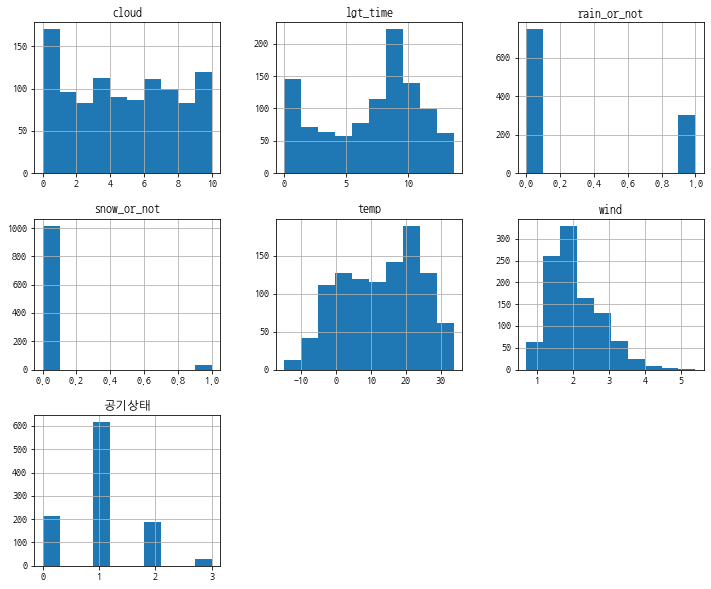

In [10]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

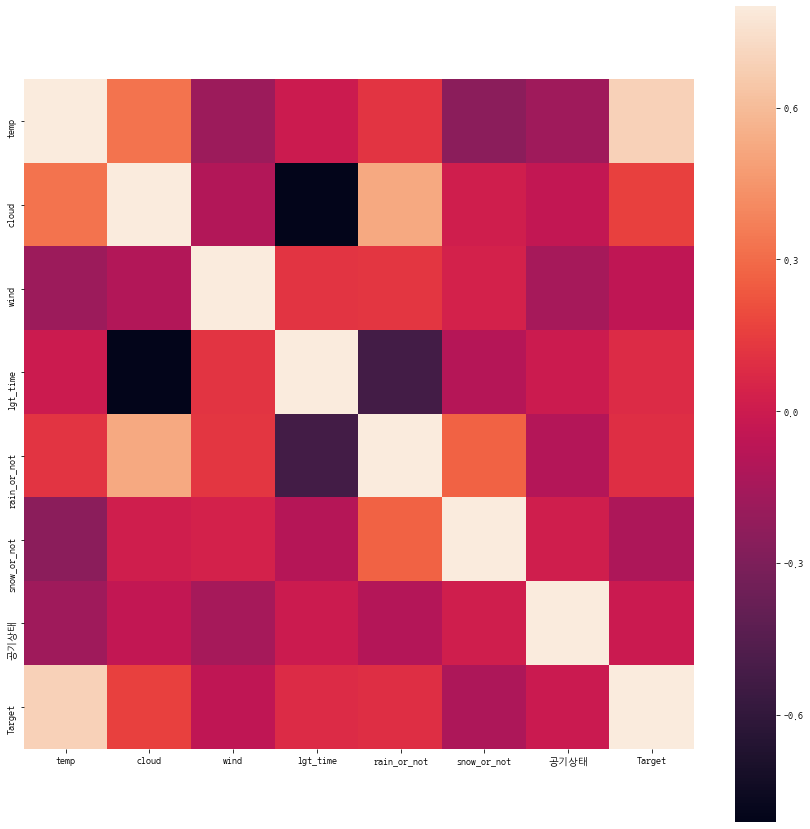

In [11]:
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [12]:
def oneHotEncode(df,colNames):
    for col in colNames:
        # 해당 컬럼의 데이터 타입이 object란 소리는 숫자가 아니다 = 분류형 데이터
        if( df[col].dtype == np.dtype('object')):
            # 더미 컬럼 생성
            dummies = pd.get_dummies(df[col],prefix=col)
            # 원본 데이터에 이어 붙이기 axis=1 컬럼방향으로 
            df = pd.concat([df,dummies],axis=1)

            # 기존의 str형 컬럼 삭제
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('분류형(category형) 컬럼 수정 전, 총 {} 개의 columns이 있었습니다.'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
#### 내가 '공기상태'라는 컬럼이 사실은 category형이라는것을 알기에 직접 dummy컬럼 생성
airCondition_dummies = pd.get_dummies(combined['공기상태'],prefix='공기상태')
combined = pd.concat([combined, airCondition_dummies], axis=1)
combined.drop(['공기상태'],axis = 1 , inplace=True)
######################################################################################
print('분류형(category형) 컬럼 수정 후, 총 {} 개의 columns이 있었습니다.'.format(combined.shape[1]))

분류형(category형) 컬럼 수정 전, 총 7 개의 columns이 있었습니다.
분류형(category형) 컬럼 수정 후, 총 10 개의 columns이 있었습니다.


In [14]:
# 공기상태_0,공기상태_1,공기상태_2가 전부 0이면,   공기상태_3이 1이란 소리고
#                                                               공기상태가 '매우나쁨' 임을 추정할수 있다.
# 그런이유로 공기상태_3삭제
combined.drop(['공기상태_3'],axis = 1 , inplace=True)

In [15]:
Xy = pd.concat([target,combined], axis=1)
# Xy.head(1)

In [16]:
# 첫 2년 : 732 일
cut_line = 732
def split_combined():
    global combined
    train = combined[:cut_line]
    test = combined[cut_line:]

    return train , test 
  
train, test = split_combined()

train.shape

(732, 9)

In [17]:
# 신경망 모델 생성
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
# optimizer에 여러 방식이 있다.
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

W0722 14:59:02.965276 11676 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0722 14:59:02.981235 11676 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0722 14:59:02.984196 11676 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0722 14:59:03.039050 11676 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1280      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 166,145
Trainable params: 166,145
Non-trainable params: 0
_________________________________________________________________


In [18]:
# 인공 신경망에 의해 생성된 weight 자료를 저장하기 위해서
checkpoint_name = item+grouped_by+'-Weights-{epoch:03d}--{val_loss:.5f}-cat02-vf05.hdf5'

# save_best_only값이 저장되어, 모든 weight값을 저장하지 않고, val_loss값이 줄어들때마다(적을수록 좋다.) 저장
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [21]:
# 예제에서는 target을 대회에서 주는 target데이터를 기준으로 미리 train데이터와 맞춰졌있지만
# gs/lv데이터는 아니다. 그래서 위에서 나누는 기준으로 삼은cut_line=732을 이용하여 데이터 사이즈를 맞춰준다.
# 아니면 애시당초에(맨처음에) 훈련용 데이터와 타겟을 만들어 놓는것도 좋다.
NN_model.fit(train, target[:cut_line], epochs=1000, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

W0722 14:37:19.270537  3816 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0722 14:37:19.378273  3816 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 585 samples, validate on 147 samples
Epoch 1/1000
585/585 [==============================] - 0s 503us/step - loss: 1346.4346 - mean_absolute_error: 1346.4346 - val_loss: 611.7590 - val_mean_absolute_error: 611.7590

Epoch 00001: val_loss improved from inf to 611.75898, saving model to 제모제date-Weights-001--611.75898-cat02-vf05.hdf5
Epoch 2/1000
585/585 [==============================] - 0s 78us/step - loss: 902.0175 - mean_absolute_error: 902.0175 - val_loss: 615.9567 - val_mean_absolute_error: 615.9567

Epoch 00002: val_loss did not improve from 611.75898
Epoch 3/1000
585/585 [==============================] - 0s 80us/step - loss: 580.4973 - mean_absolute_error: 580.4973 - val_loss: 459.7765 - val_mean_absolute_error: 459.7765

Epoch 00003: val_loss improved from 611.75898 to 459.77646, saving model to 제모제date-Weights-003--459.77646-cat02-vf05.hdf5
Epoch 4/1000
585/585 [==============================] - 0s 77us/step - loss: 560.9299 - mean_absolute_error: 560.9299 - val_loss: 

585/585 [==============================] - 0s 89us/step - loss: 481.9188 - mean_absolute_error: 481.9188 - val_loss: 445.2988 - val_mean_absolute_error: 445.2988

Epoch 00070: val_loss did not improve from 386.31710
Epoch 71/1000
585/585 [==============================] - 0s 90us/step - loss: 479.7823 - mean_absolute_error: 479.7823 - val_loss: 415.9843 - val_mean_absolute_error: 415.9843

Epoch 00071: val_loss did not improve from 386.31710
Epoch 72/1000
585/585 [==============================] - 0s 95us/step - loss: 478.8987 - mean_absolute_error: 478.8987 - val_loss: 422.5658 - val_mean_absolute_error: 422.5658

Epoch 00072: val_loss did not improve from 386.31710
Epoch 73/1000
585/585 [==============================] - 0s 94us/step - loss: 477.5039 - mean_absolute_error: 477.5039 - val_loss: 392.4270 - val_mean_absolute_error: 392.4270

Epoch 00073: val_loss did not improve from 386.31710
Epoch 74/1000
585/585 [==============================] - 0s 95us/step - loss: 478.4254 - mean_

585/585 [==============================] - 0s 131us/step - loss: 435.5851 - mean_absolute_error: 435.5851 - val_loss: 405.4252 - val_mean_absolute_error: 405.4252

Epoch 00140: val_loss did not improve from 371.32956
Epoch 141/1000
585/585 [==============================] - 0s 143us/step - loss: 443.7201 - mean_absolute_error: 443.7201 - val_loss: 435.1405 - val_mean_absolute_error: 435.1405

Epoch 00141: val_loss did not improve from 371.32956
Epoch 142/1000
585/585 [==============================] - 0s 131us/step - loss: 431.6660 - mean_absolute_error: 431.6660 - val_loss: 407.8166 - val_mean_absolute_error: 407.8166

Epoch 00142: val_loss did not improve from 371.32956
Epoch 143/1000
585/585 [==============================] - 0s 121us/step - loss: 436.9203 - mean_absolute_error: 436.9203 - val_loss: 424.6691 - val_mean_absolute_error: 424.6691

Epoch 00143: val_loss did not improve from 371.32956
Epoch 144/1000
585/585 [==============================] - 0s 109us/step - loss: 434.453

585/585 [==============================] - 0s 130us/step - loss: 408.6933 - mean_absolute_error: 408.6933 - val_loss: 449.2053 - val_mean_absolute_error: 449.2053

Epoch 00210: val_loss did not improve from 363.22833
Epoch 211/1000
585/585 [==============================] - 0s 138us/step - loss: 410.8013 - mean_absolute_error: 410.8013 - val_loss: 441.7112 - val_mean_absolute_error: 441.7112

Epoch 00211: val_loss did not improve from 363.22833
Epoch 212/1000
585/585 [==============================] - 0s 133us/step - loss: 413.3863 - mean_absolute_error: 413.3863 - val_loss: 398.9538 - val_mean_absolute_error: 398.9538

Epoch 00212: val_loss did not improve from 363.22833
Epoch 213/1000
585/585 [==============================] - 0s 126us/step - loss: 408.8352 - mean_absolute_error: 408.8352 - val_loss: 425.4001 - val_mean_absolute_error: 425.4001

Epoch 00213: val_loss did not improve from 363.22833
Epoch 214/1000
585/585 [==============================] - 0s 138us/step - loss: 417.672

585/585 [==============================] - 0s 155us/step - loss: 395.0817 - mean_absolute_error: 395.0817 - val_loss: 435.2301 - val_mean_absolute_error: 435.2301

Epoch 00280: val_loss did not improve from 363.22833
Epoch 281/1000
585/585 [==============================] - 0s 133us/step - loss: 395.3452 - mean_absolute_error: 395.3452 - val_loss: 420.0035 - val_mean_absolute_error: 420.0035

Epoch 00281: val_loss did not improve from 363.22833
Epoch 282/1000
585/585 [==============================] - 0s 157us/step - loss: 383.5495 - mean_absolute_error: 383.5495 - val_loss: 381.6778 - val_mean_absolute_error: 381.6778

Epoch 00282: val_loss did not improve from 363.22833
Epoch 283/1000
585/585 [==============================] - 0s 150us/step - loss: 385.4445 - mean_absolute_error: 385.4445 - val_loss: 405.9162 - val_mean_absolute_error: 405.9162

Epoch 00283: val_loss did not improve from 363.22833
Epoch 284/1000
585/585 [==============================] - 0s 148us/step - loss: 387.997

585/585 [==============================] - 0s 138us/step - loss: 373.8914 - mean_absolute_error: 373.8914 - val_loss: 397.1102 - val_mean_absolute_error: 397.1102

Epoch 00350: val_loss did not improve from 363.22833
Epoch 351/1000
585/585 [==============================] - 0s 138us/step - loss: 391.2152 - mean_absolute_error: 391.2152 - val_loss: 445.0118 - val_mean_absolute_error: 445.0118

Epoch 00351: val_loss did not improve from 363.22833
Epoch 352/1000
585/585 [==============================] - 0s 142us/step - loss: 400.6873 - mean_absolute_error: 400.6873 - val_loss: 383.5884 - val_mean_absolute_error: 383.5884

Epoch 00352: val_loss did not improve from 363.22833
Epoch 353/1000
585/585 [==============================] - 0s 140us/step - loss: 387.7373 - mean_absolute_error: 387.7373 - val_loss: 363.2573 - val_mean_absolute_error: 363.2573

Epoch 00353: val_loss did not improve from 363.22833
Epoch 354/1000
585/585 [==============================] - 0s 145us/step - loss: 386.545

585/585 [==============================] - 0s 135us/step - loss: 359.1266 - mean_absolute_error: 359.1266 - val_loss: 375.2793 - val_mean_absolute_error: 375.2793

Epoch 00420: val_loss did not improve from 347.51044
Epoch 421/1000
585/585 [==============================] - 0s 148us/step - loss: 359.4039 - mean_absolute_error: 359.4039 - val_loss: 395.3232 - val_mean_absolute_error: 395.3232

Epoch 00421: val_loss did not improve from 347.51044
Epoch 422/1000
585/585 [==============================] - 0s 160us/step - loss: 362.6573 - mean_absolute_error: 362.6573 - val_loss: 389.7544 - val_mean_absolute_error: 389.7544

Epoch 00422: val_loss did not improve from 347.51044
Epoch 423/1000
585/585 [==============================] - 0s 162us/step - loss: 358.6211 - mean_absolute_error: 358.6211 - val_loss: 408.7005 - val_mean_absolute_error: 408.7005

Epoch 00423: val_loss did not improve from 347.51044
Epoch 424/1000
585/585 [==============================] - 0s 157us/step - loss: 354.250

585/585 [==============================] - 0s 170us/step - loss: 345.2838 - mean_absolute_error: 345.2838 - val_loss: 387.1573 - val_mean_absolute_error: 387.1573

Epoch 00490: val_loss did not improve from 347.51044
Epoch 491/1000
585/585 [==============================] - 0s 142us/step - loss: 333.0203 - mean_absolute_error: 333.0203 - val_loss: 391.9469 - val_mean_absolute_error: 391.9469

Epoch 00491: val_loss did not improve from 347.51044
Epoch 492/1000
585/585 [==============================] - 0s 167us/step - loss: 341.0115 - mean_absolute_error: 341.0115 - val_loss: 417.1330 - val_mean_absolute_error: 417.1330

Epoch 00492: val_loss did not improve from 347.51044
Epoch 493/1000
585/585 [==============================] - 0s 153us/step - loss: 335.1950 - mean_absolute_error: 335.1950 - val_loss: 397.3573 - val_mean_absolute_error: 397.3573

Epoch 00493: val_loss did not improve from 347.51044
Epoch 494/1000
585/585 [==============================] - 0s 159us/step - loss: 341.239

585/585 [==============================] - 0s 155us/step - loss: 324.7139 - mean_absolute_error: 324.7139 - val_loss: 400.1156 - val_mean_absolute_error: 400.1156

Epoch 00560: val_loss did not improve from 347.51044
Epoch 561/1000
585/585 [==============================] - 0s 167us/step - loss: 318.0945 - mean_absolute_error: 318.0945 - val_loss: 393.5771 - val_mean_absolute_error: 393.5771

Epoch 00561: val_loss did not improve from 347.51044
Epoch 562/1000
585/585 [==============================] - 0s 174us/step - loss: 325.4865 - mean_absolute_error: 325.4865 - val_loss: 427.3873 - val_mean_absolute_error: 427.3873

Epoch 00562: val_loss did not improve from 347.51044
Epoch 563/1000
585/585 [==============================] - 0s 169us/step - loss: 325.6974 - mean_absolute_error: 325.6974 - val_loss: 393.7558 - val_mean_absolute_error: 393.7558

Epoch 00563: val_loss did not improve from 347.51044
Epoch 564/1000
585/585 [==============================] - 0s 159us/step - loss: 315.961

585/585 [==============================] - 0s 148us/step - loss: 316.3579 - mean_absolute_error: 316.3579 - val_loss: 383.8983 - val_mean_absolute_error: 383.8983

Epoch 00630: val_loss did not improve from 347.51044
Epoch 631/1000
585/585 [==============================] - 0s 159us/step - loss: 295.6852 - mean_absolute_error: 295.6852 - val_loss: 435.8152 - val_mean_absolute_error: 435.8152

Epoch 00631: val_loss did not improve from 347.51044
Epoch 632/1000
585/585 [==============================] - 0s 136us/step - loss: 307.6724 - mean_absolute_error: 307.6724 - val_loss: 399.0462 - val_mean_absolute_error: 399.0462

Epoch 00632: val_loss did not improve from 347.51044
Epoch 633/1000
585/585 [==============================] - 0s 150us/step - loss: 297.9436 - mean_absolute_error: 297.9436 - val_loss: 421.1009 - val_mean_absolute_error: 421.1009

Epoch 00633: val_loss did not improve from 347.51044
Epoch 634/1000
585/585 [==============================] - 0s 153us/step - loss: 298.731

585/585 [==============================] - 0s 126us/step - loss: 292.9119 - mean_absolute_error: 292.9119 - val_loss: 442.3178 - val_mean_absolute_error: 442.3178

Epoch 00700: val_loss did not improve from 347.51044
Epoch 701/1000
585/585 [==============================] - 0s 138us/step - loss: 315.4767 - mean_absolute_error: 315.4767 - val_loss: 445.4483 - val_mean_absolute_error: 445.4483

Epoch 00701: val_loss did not improve from 347.51044
Epoch 702/1000
585/585 [==============================] - 0s 140us/step - loss: 294.9623 - mean_absolute_error: 294.9623 - val_loss: 414.2078 - val_mean_absolute_error: 414.2078

Epoch 00702: val_loss did not improve from 347.51044
Epoch 703/1000
585/585 [==============================] - 0s 153us/step - loss: 280.6769 - mean_absolute_error: 280.6769 - val_loss: 410.3574 - val_mean_absolute_error: 410.3574

Epoch 00703: val_loss did not improve from 347.51044
Epoch 704/1000
585/585 [==============================] - 0s 153us/step - loss: 279.040

585/585 [==============================] - 0s 136us/step - loss: 266.9409 - mean_absolute_error: 266.9409 - val_loss: 446.1815 - val_mean_absolute_error: 446.1815

Epoch 00770: val_loss did not improve from 347.51044
Epoch 771/1000
585/585 [==============================] - 0s 143us/step - loss: 262.3115 - mean_absolute_error: 262.3115 - val_loss: 444.4220 - val_mean_absolute_error: 444.4220

Epoch 00771: val_loss did not improve from 347.51044
Epoch 772/1000
585/585 [==============================] - 0s 160us/step - loss: 259.8765 - mean_absolute_error: 259.8765 - val_loss: 434.1581 - val_mean_absolute_error: 434.1581

Epoch 00772: val_loss did not improve from 347.51044
Epoch 773/1000
585/585 [==============================] - 0s 153us/step - loss: 262.3035 - mean_absolute_error: 262.3035 - val_loss: 433.7123 - val_mean_absolute_error: 433.7123

Epoch 00773: val_loss did not improve from 347.51044
Epoch 774/1000
585/585 [==============================] - 0s 157us/step - loss: 272.023

585/585 [==============================] - 0s 138us/step - loss: 243.4870 - mean_absolute_error: 243.4870 - val_loss: 447.9948 - val_mean_absolute_error: 447.9948

Epoch 00840: val_loss did not improve from 347.51044
Epoch 841/1000
585/585 [==============================] - 0s 142us/step - loss: 249.3580 - mean_absolute_error: 249.3580 - val_loss: 426.9792 - val_mean_absolute_error: 426.9792

Epoch 00841: val_loss did not improve from 347.51044
Epoch 842/1000
585/585 [==============================] - 0s 159us/step - loss: 252.3809 - mean_absolute_error: 252.3809 - val_loss: 422.7827 - val_mean_absolute_error: 422.7827

Epoch 00842: val_loss did not improve from 347.51044
Epoch 843/1000
585/585 [==============================] - 0s 147us/step - loss: 249.7387 - mean_absolute_error: 249.7387 - val_loss: 449.2651 - val_mean_absolute_error: 449.2651

Epoch 00843: val_loss did not improve from 347.51044
Epoch 844/1000
585/585 [==============================] - 0s 162us/step - loss: 256.938

585/585 [==============================] - 0s 142us/step - loss: 254.5499 - mean_absolute_error: 254.5499 - val_loss: 434.1908 - val_mean_absolute_error: 434.1908

Epoch 00910: val_loss did not improve from 347.51044
Epoch 911/1000
585/585 [==============================] - 0s 140us/step - loss: 270.5055 - mean_absolute_error: 270.5055 - val_loss: 435.0720 - val_mean_absolute_error: 435.0720

Epoch 00911: val_loss did not improve from 347.51044
Epoch 912/1000
585/585 [==============================] - 0s 150us/step - loss: 240.8900 - mean_absolute_error: 240.8900 - val_loss: 459.6922 - val_mean_absolute_error: 459.6922

Epoch 00912: val_loss did not improve from 347.51044
Epoch 913/1000
585/585 [==============================] - 0s 155us/step - loss: 261.2680 - mean_absolute_error: 261.2680 - val_loss: 451.8734 - val_mean_absolute_error: 451.8734

Epoch 00913: val_loss did not improve from 347.51044
Epoch 914/1000
585/585 [==============================] - 0s 152us/step - loss: 250.516

585/585 [==============================] - 0s 162us/step - loss: 234.5398 - mean_absolute_error: 234.5398 - val_loss: 458.4788 - val_mean_absolute_error: 458.4788

Epoch 00980: val_loss did not improve from 347.51044
Epoch 981/1000
585/585 [==============================] - 0s 199us/step - loss: 227.8222 - mean_absolute_error: 227.8222 - val_loss: 431.4346 - val_mean_absolute_error: 431.4346

Epoch 00981: val_loss did not improve from 347.51044
Epoch 982/1000
585/585 [==============================] - 0s 191us/step - loss: 229.1301 - mean_absolute_error: 229.1301 - val_loss: 466.9421 - val_mean_absolute_error: 466.9421

Epoch 00982: val_loss did not improve from 347.51044
Epoch 983/1000
585/585 [==============================] - 0s 198us/step - loss: 234.8424 - mean_absolute_error: 234.8424 - val_loss: 447.0937 - val_mean_absolute_error: 447.0937

Epoch 00983: val_loss did not improve from 347.51044
Epoch 984/1000
585/585 [==============================] - 0s 172us/step - loss: 218.244

In [19]:
# 500번을 학습하여 나온 결과들중, 가장 좋은(마지막에 저장된) Weights파일을 가져온다.
# Load wights file of the best model :
# 파일은 이 코드랑 같은 폴더에 위치해있어야 작동
wights_file = '제모제date-Weights-387--347.51044-cat02-vf05.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

W0722 14:59:06.432651 11676 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0722 14:59:06.432651 11676 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [20]:
#2016~2018전체를 난수로 0.67:0.33 = 2:1
# train3 = combined.loc[:,'temp':]
# target3 = combined.loc[:,'qty']
# train_X, val_X, train_y, val_y = train_test_split(train3, target3, test_size = 0.33, random_state = 14)

# 2016~2017 : 훈련 / 2018 검증 2:1
# 1~732 / 732~1096
trainXy = Xy[:cut_line]
testXy = Xy[cut_line:]

# 독립변수들
train_X = trainXy.loc[:,'temp':]
# 정답(판매량)
train_y = trainXy.loc[:,'qty']

val_X = testXy.loc[:,'temp':]
val_y = testXy.loc[:,'qty']

print('여기서 점수란 R-square값을 의미한다.')
# RandomForest 회귀분석
RFmodel = RandomForestRegressor()
RFmodel.fit(train_X,train_y)
# Get the mean absolute error on the validation data
RFpredicted = RFmodel.predict(val_X)
MAE = mean_absolute_error(val_y , RFpredicted)
print('Random forest을 이용한 %s의 회귀분석 결과 :'%item)
# print('Random forest validation MAE = ', MAE)
print('훈련세트점수 : {:.3f}'.format(RFmodel.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(RFmodel.score(val_X, val_y)))
    
# XGBRegressor 회귀분석
XGBModel = XGBRegressor(objective='reg:squarederror')
XGBModel.fit(train_X,train_y , verbose=False)
# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost을 이용한 %s의 회귀분석 결과 :'%item)
# print('XGBoost validation MAE = ',MAE)
print('훈련세트점수 : {:.3f}'.format(XGBModel.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(XGBModel.score(val_X, val_y)))

linReg = LinearRegression().fit(train_X, train_y)
print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(linReg.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(linReg.score(val_X, val_y)))

ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(train_X, train_y)
print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(ridge.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(ridge.score(val_X, val_y)))

lasso = Lasso(alpha=0.1, max_iter=1000).fit(train_X, train_y)
print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(lasso.score(train_X, train_y)) )
print('검증세트점수 : {:.3f}'.format(lasso.score(val_X, val_y)) )

columns_in_data = list(train_X.columns)
customF = formulaGen(target='qty',ind_features=columns_in_data)
olsModel = sm.OLS.from_formula(customF, data=trainXy).fit()
print('OLS을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(olsModel.rsquared) )
print('검증세트점수 : {:.3f}'.format( r2_score(val_y, olsModel.predict(val_X))   ) )

여기서 점수란 R-square값을 의미한다.
Random forest을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.925
검증세트점수 : 0.361
XGBoost을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.799
검증세트점수 : 0.425
LinearRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.516
검증세트점수 : 0.423
RidgeRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.509
검증세트점수 : 0.435
LassoRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.516
검증세트점수 : 0.423
OLS을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.516
검증세트점수 : 0.423


In [21]:
print(item, 'ols model')
# ind_features = 넣고 싶은 독립변수를 리스트로 넣어주면 알아서 formula생성해 준다.
# customF = formulaGen(target='qty',ind_features=['temp'])
# print(customF) qty ~ temp
# customF = formulaGen(target='qty',ind_features=['temp','cloud'])
# print(customF) # qty ~ temp + cloud
# columns_in_data = 
# ['temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not', 'snow_or_not', '공기상태_0', '공기상태_1', '공기상태_2']
# formulaGen은 단순 1차 다항식을 제조해준다.
# customF = formulaGen(target='qty',ind_features=['temp'])
customF = 'qty ~ temp'
olsModel = sm.OLS.from_formula(customF, data=trainXy).fit()

print('사람이 직접 식을 때려 박았을때 : {:.3f}'.format(r2_score(val_y, olsModel.predict(val_X))) )


olsModel.summary()

제모제 ols model
사람이 직접 식을 때려 박았을때 : 0.273


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    qty   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     673.7
Date:                Mon, 22 Jul 2019   Prob (F-statistic):          9.58e-106
Time:                        14:59:07   Log-Likelihood:                -5834.3
No. Observations:                 732   AIC:                         1.167e+04
Df Residuals:                     730   BIC:                         1.168e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    537.7089     36.986     14.538      0.000     465.098     610.320
temp          58.8012      2.265     25.957      0.000      54.354      63.249
==============================================================================
Omnibus:                       15.816   Durbin-Watson:                   0.461
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.135
Skew:                           0.344   Prob(JB):                     0.000314
Kurtosis:                       2.763   Cond. No.                         23.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
# col_list = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10', 'rain_or_not_o', 'snow_or_not_o',
#             '공기상태_0', '공기상태_1', '공기상태_2']
col_list = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10', 'rain_or_not_o', 'snow_or_not_o',
            '공기상태']
combined = Xy.loc[:,'temp':]
target = Xy.loc[:,'qty']

# 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
predictions = NN_model.predict(combined)
# RandomForest 회귀분석 예측 qty생산
RFpredicted = RFmodel.predict(combined)
# XGBRegressor 회귀분석 예측 qty생산
XGBpredictions = XGBModel.predict(combined)
# linearRegression 회귀분석 예측 qty생산
linPred = linReg.predict(combined)
# Ridge 회귀분석 예측 qty생산
ridPred = ridge.predict(combined)
# Lasso 회귀분석 예측 qty생산
lassoPred = lasso.predict(combined)
# OLS 회귀분석 예측 qty생산
olsPred = olsModel.predict(combined)

result_df = pd.DataFrame()
result_df['date'] = lv_day_w['date']
result_df['qty'] = Xy.loc[:,'qty']

# print("keras 신경망 predictions",predictions.shape)
result_df['keras_qty'] = predictions

# print("randomforest 예상",RFpredicted.shape)
result_df['rf_qty'] = RFpredicted

# print("XGBpredictions",XGBpredictions.shape)
result_df['xgb_qty'] = XGBpredictions

# print("linearRegression 예상",RFpredicted.shape)
result_df['lin_qty'] = linPred

# print("Ridge 예상",RFpredicted.shape)
result_df['ridge_qty'] = ridPred

# print("Lasso 예상",RFpredicted.shape)
result_df['lasso_qty'] = lassoPred

# print("OLS 예상",RFpredicted.shape)
result_df['ols_qty'] = olsPred

In [23]:
# 예측률 계산
# https://yamalab.tistory.com/46
# RMSE (Root Mean Squared Error) : 
# OLS 추정에서 일반적인 표준 오차이다. 예측 대상의 scale(단위 크기)에 주의해야하는 단점이 있다. 
# MSE는 root를 수식에서 제외, SSE는 root와 분모를 제외한 수식으로, SE가 붙은 척도들은 거기서 거기인 척도들이라고 보면 된다.
# 다만 디테일한 사용법에 차이가 있을 뿐.

# MAPE (Mean Absolute Percentage Error) :

# 위 방법의 단점을 보완한 것이다. 
# At는 실제값, Ft는 예측값인데, 이를 At로 나누어서 오차를 절대적 크기로 보는것이 아닌 비율의 크기로 보고자 하는 것이 핵심이다.
# 이 방법은 At가 0에 가까울수록 비정상적인 값이 나온다는 단점이 있다.

# mre가 0에 가까울수록 좋은 모델
result_df['mape_keras'] = abs((result_df.qty - result_df.keras_qty) / result_df.qty )
result_df['mape_rf'] = abs((result_df.qty - result_df.rf_qty) / result_df.qty )
result_df['mape_xgb'] = abs((result_df.qty - result_df.xgb_qty) / result_df.qty )
result_df['mape_lin'] = abs((result_df.qty - result_df.lin_qty) / result_df.qty )
result_df['mape_ridge'] = abs((result_df.qty - result_df.ridge_qty) / result_df.qty )
result_df['mape_lasso'] = abs((result_df.qty - result_df.lasso_qty) / result_df.qty )
result_df['mape_ols'] = abs((result_df.qty - result_df.ols_qty) / result_df.qty )

print('Keras 인공 신경망 모델 MAPE \t: {:<.2f}'.format(result_df['mape_keras'].sum() / result_df.shape[0] ))
# print('RandomForest 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_rf'].sum() / result_df.shape[0] ))
# print('XGBoosting  모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_xgb'].sum() / result_df.shape[0] ))
print('Linear 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_lin'].sum() / result_df.shape[0] ))
print('Ridge 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_ridge'].sum() / result_df.shape[0] ))
print('Lasso 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_lasso'].sum() / result_df.shape[0] ))
print('OLS 모델 MAPE \t\t\t: {:<.2f}'.format(result_df['mape_ols'].sum() / result_df.shape[0] ))

Keras 인공 신경망 모델 MAPE 	: 0.46
Linear 모델 MAPE 		: 0.89
Ridge 모델 MAPE 		: 0.91
Lasso 모델 MAPE 		: 0.89
OLS 모델 MAPE 			: 0.94


In [24]:
w_seoul.head(1)
w_seoul.shape
result_date_col = result_df.date
result_date_col.shape


(1051,)

In [25]:
Xy['공기상태_3'] = Xy[["공기상태_0",'공기상태_1','공기상태_2']].sum(axis=1)
Xy['공기상태_3'] = Xy['공기상태_3'].apply(lambda x : 1 if x==0 else 0)
Xy['date'] = result_date_col

XyAndPm10 = pd.merge(Xy, w_seoul[['date','PM10']], on='date', how='left')
XyAndPm10.head(1)

,qty,temp,cloud,wind,lgt_time,rain_or_not,snow_or_not,공기상태_0,공기상태_1,공기상태_2,공기상태_3,date,PM10
0,72,1.2,7.0,1.6,2.1,0,0,0,0,1,0,2016-01-01,68.6965


In [26]:
print(Xy.shape)
print(result_df.shape)

(1051, 12)
(1051, 16)


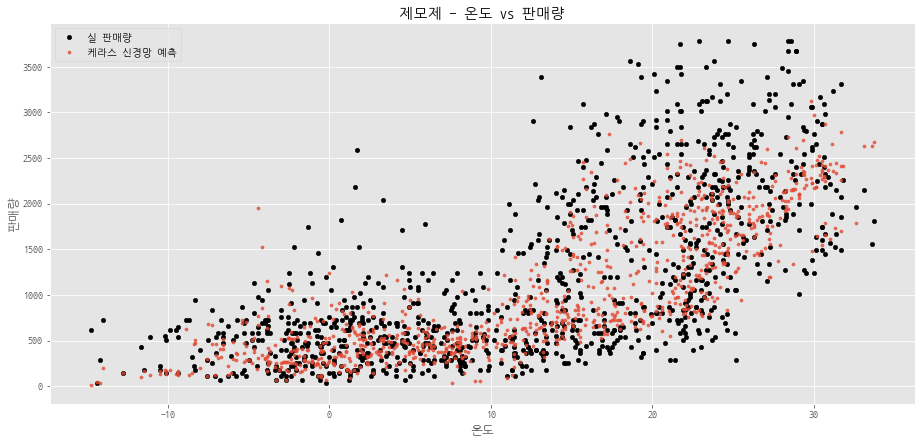

In [27]:
# 독립변수 Xy의 col번호: 0=qty
# ['qty', 'temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not','snow_or_not', 
#                                                   '공기상태_0', '공기상태_1', '공기상태_2','공기상태_3','aircon',
#                                                     'date','PM10']
n=1
# alpha 값 0~1
alp = 0.8
# scatter plot 점 크기
dot_size = 10

matplotlib.rcParams['font.family'] = 'NanumGothicCoding'
plt.figure(figsize=(15.5,7))
plt.style.use('ggplot')
# plt.title('%s - %s vs 판매량' % (item, Xy.columns[n]) )
plt.title('%s - %s vs 판매량' % (item, '온도') )
plt.scatter(Xy.iloc[:,n],result_df.qty, label = '실 판매량', s=20, c='k')
plt.scatter(Xy.iloc[:,n],result_df.keras_qty, label = '케라스 신경망 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.rf_qty, label = 'RandomForest 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.xgb_qty, label = 'XGBoosting 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.lin_qty, label = '선형 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.ridge_qty, label = 'Ridge 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.ols_qty, label = 'OLS 예측', alpha=alp, s=dot_size)

# X axis
# plt.xlabel('{}'.format(Xy.columns[n]))
plt.xlabel('온도')

# y axis
plt.ylabel('판매량')

# 범례
plt.legend()
figure_name = 'D:/project/contest/ppt/picture/%s_판매량(3년).png'%item
plt.savefig(figure_name)
plt.show()

In [28]:
def airconall(x):
    if x[0]==1:
        return '좋음'
    elif x[1]==1:
        return '보통'
    elif x[2]==1:
        return '나쁨'
    elif x[3]==1:
        return '매우나쁨'

Xy['aircon'] =Xy[['공기상태_0','공기상태_1','공기상태_2','공기상태_3']].apply(airconall, axis=1)

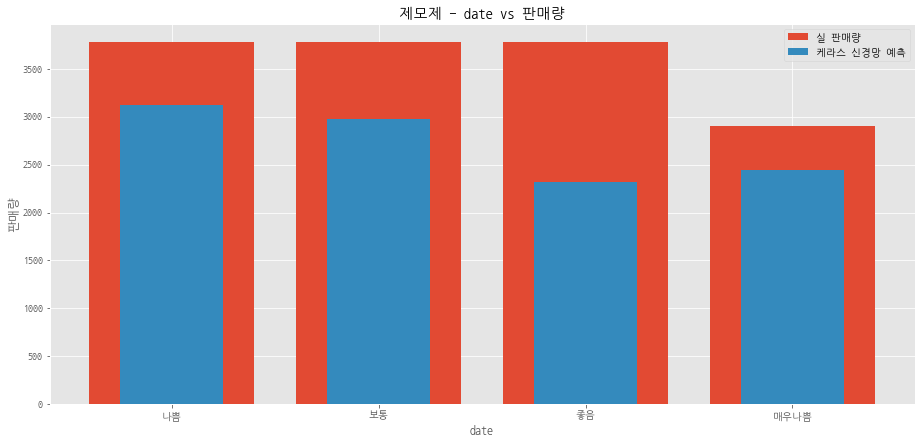

In [29]:
# 독립변수 Xy의 col번호: 0=qty
# ['qty', 'temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not','snow_or_not', 
#                                                   '공기상태_0', '공기상태_1', '공기상태_2','공기상태_2', 'aircon']
# 1~11
n=11
# alpha 값 0~1
alp = 0.8
# scatter plot 점 크기
dot_size = 10

matplotlib.rcParams['font.family'] = 'NanumGothicCoding'
plt.figure(figsize=(15.5,7))
plt.style.use('ggplot')
plt.title('%s - %s vs 판매량' % (item, Xy.columns[n]) )

ind = np.arange(4)
plt.bar(Xy.aircon,result_df.qty, label = '실 판매량')
plt.bar(Xy.aircon,result_df.keras_qty, label = '케라스 신경망 예측',width = 0.5)
# plt.bar(Xy.aircon,result_df.rf_qty, label = 'RandomForest 예측')
# plt.bar(Xy.aircon,result_df.xgb_qty, label = 'XGBoosting 예측')
# plt.bar(Xy.aircon,result_df.lin_qty, label = '선형 예측')
# plt.bar(Xy.aircon,result_df.ridge_qty, label = 'Ridge 예측')
# plt.bar(Xy.aircon,result_df.ols_qty, label = 'OLS 예측')

# X axis
plt.xlabel('{}'.format(Xy.columns[n]))

# y axis
plt.ylabel('판매량')

# 범례
plt.legend()
plt.show()

In [30]:
tt = ['temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not', 'snow_or_not', 'aircon']
print(tt)

['temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not', 'snow_or_not', 'aircon']


In [31]:
Xy.head(2)
# result_df.head(2)
result_Xy = pd.concat([result_df, Xy[tt]],axis=1)
result_Xy.head(2)

,date,qty,keras_qty,rf_qty,xgb_qty,lin_qty,ridge_qty,lasso_qty,ols_qty,mape_keras,...,mape_ridge,mape_lasso,mape_ols,temp,cloud,wind,lgt_time,rain_or_not,snow_or_not,aircon
0,2016-01-01,72,313.763306,173.6,644.043152,435.736604,524.239881,437.292822,608.270411,3.357824,...,6.281109,5.073511,7.448200,1.2,7.0,1.6,2.1,0,0,나쁨
1,2016-01-02,145,437.532104,381.0,600.106567,753.299325,828.462010,754.481313,872.875953,2.017463,...,4.713531,4.203319,5.019834,5.7,7.8,2.0,3.6,0,0,보통


In [32]:
result_Xy.columns

Index(['date', 'qty', 'keras_qty', 'rf_qty', 'xgb_qty', 'lin_qty', 'ridge_qty',
       'lasso_qty', 'ols_qty', 'mape_keras', 'mape_rf', 'mape_xgb', 'mape_lin',
       'mape_ridge', 'mape_lasso', 'mape_ols', 'temp', 'cloud', 'wind',
       'lgt_time', 'rain_or_not', 'snow_or_not', 'aircon'],
      dtype='object')

In [33]:
def tempCat(x):
    if x < -10:
        return 0
    elif x < 0:
        return 1
    elif x < 10:
        return 2
    elif x < 20:
        return 3
    elif x < 30:
        return 4
    else:
        return 5
    
w_seoul['temp_cat'] = w_seoul.temp.apply(tempCat)
XyAndPm10 = pd.merge(result_Xy, w_seoul[['date','temp_cat']], on='date', how='left')
XyAndPm10.head()

,date,qty,keras_qty,rf_qty,xgb_qty,lin_qty,ridge_qty,lasso_qty,ols_qty,mape_keras,...,mape_lasso,mape_ols,temp,cloud,wind,lgt_time,rain_or_not,snow_or_not,aircon,temp_cat
0,2016-01-01,72,313.763306,173.6,644.043152,435.736604,524.239881,437.292822,608.270411,3.357824,...,5.073511,7.448200,1.2,7.0,1.6,2.1,0,0,나쁨,2
1,2016-01-02,145,437.532104,381.0,600.106567,753.299325,828.462010,754.481313,872.875953,2.017463,...,4.203319,5.019834,5.7,7.8,2.0,3.6,0,0,보통,2
2,2016-01-03,108,521.220154,162.4,724.709595,796.503022,841.198107,797.859877,919.916939,3.826113,...,6.387591,7.517749,6.5,7.5,1.8,2.2,0,0,나쁨,2
3,2016-01-04,290,376.880310,373.3,564.239380,798.017641,838.243284,798.635635,655.311397,0.299587,...,1.753916,1.259694,2.0,4.4,3.1,8.6,0,0,나쁨,2
4,2016-01-05,108,177.262009,231.8,502.412994,356.279589,460.279226,357.069260,378.945608,0.641315,...,2.306197,2.508756,-2.7,3.4,2.3,7.9,0,0,보통,1


In [34]:
p_df = pd.pivot_table(XyAndPm10[['date','qty', 'keras_qty', 'rf_qty', 'xgb_qty', 'lin_qty', 
                                 'ridge_qty','lasso_qty', 'ols_qty', 'temp_cat']],
                     values = ['qty', 'keras_qty', 'rf_qty', 'xgb_qty', 
                               'lin_qty', 'ridge_qty','lasso_qty', 'ols_qty'],
                     index=['temp_cat'],
                     aggfunc = np.sum)
p_df = p_df.iloc[:,[4,0,1,2,3,5,6,7]]
p_df

,qty,keras_qty,lasso_qty,lin_qty,ols_qty,rf_qty,ridge_qty,xgb_qty
temp_cat,,,,,,,,
0,4566,1592.703003,-2717.713853,-2726.428682,-2176.895870,5867.6,-843.994702,6233.634277
1,79292,63309.460938,51336.001655,51319.537482,51823.517476,80796.4,64580.818363,83369.335938
2,149757,121516.187500,196150.390158,196144.904880,207883.060230,159598.8,208948.599255,150335.125000
3,315569,270877.968750,372363.568589,372406.406009,381195.822305,340929.9,369324.258122,317854.625000
4,619867,537977.937500,605820.633847,605727.798525,623825.605394,633195.1,588819.067617,631488.750000
5,86473,91405.437500,96181.393860,96184.395239,94457.165243,102413.8,91428.963514,99665.000000


In [35]:
# 8개 판매량

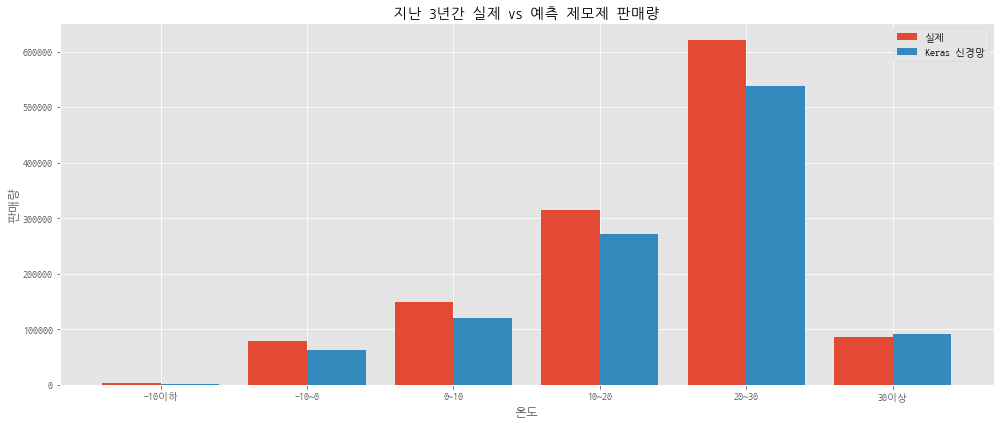

In [36]:
# 사이즈 변경 
rcParams['figure.figsize'] = 14, 6

# 공기상태 길이 만큼 x축 칸 생성
ind = np.arange(len(p_df.index))
# 바의 너비 설정
width = 0.4

# 한 그래프에 여러 값의 바그래프를 넣기 위한 그래프 객체 생성
fig, ax = plt.subplots()

# 각각의 그래프 생성
rects1 = ax.bar(ind - width/2, p_df.qty, width, label = '실제')
rects2 = ax.bar(ind + width/2, p_df.keras_qty, width, label = 'Keras 신경망')
# rects3 = ax.bar(ind - width*2, p_df.lasso_qty, width, label = 'Lasso')
# rects4 = ax.bar(ind - width*1, p_df.lin_qty, width, label = 'Linear')
# rects5 = ax.bar(ind + width*0, p_df.ols_qty, width, label = 'OLS')
# rects6 = ax.bar(ind + width*1, p_df.rf_qty, width, label = 'RandomForest')
# rects7 = ax.bar(ind + width*2, p_df.ridge_qty, width, label = 'Ridge')
# rects8 = ax.bar(ind + width*3, p_df.xgb_qty, width, label = 'XGB', color = 'green')

# 제목
ax.set_title('지난 3년간 실제 vs 예측 %s 판매량'%item)

# y축
ax.set_ylabel('판매량')

# x축
ax.set_xticks(ind)

# x 값 이름
ax.set_xticklabels(('-10이하','-10~0','0~10','10~20','20~30','30이상'))
ax.set_xlabel('온도')

# 범례
ax.legend()

fig.tight_layout()
figure_name = 'D:/project/contest/ppt/picture/실제vs예측_%s_판매량(3년).png'%item
plt.savefig(figure_name)
plt.show()